# Homework 4: Final Project
Taxis are widely used in New York City and the recorded information of where and when taxi cabs are requested can be valuable to understand traffic flow and movement patterns in the city. The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC). The For-Hire Vehicle (“FHV”) trip records include fields capturing the dispatching base license number and the pick-up date, time, and taxi zone location ID (shape file below). These records are generated from the FHV Trip Record submissions made by bases. 

In particular, we will study how the COVID-19 pandemic affected taxi ridership as well as pickup-dropoff location patterns in NYC. We can think of March 2020 to be a sort of natural experiment to understand how increased remote working would change city traffic patterns. The key challenge is that the data that we consider is highly seasonal. Seasonality is a characteristic of a time series in which the data experiences regular and predictable changes that recur every calendar year, as a result we will have to tease out the differences between changes due to seasonality versus changes due to COVID-19.

The homework assignment will directly build on the reading and reflection for the last week.

### Setup. Accessing and Loading The Dataset
The dataset in question covers taxi trips in NYC in the first six months of 2020. There are millions of such trips, and we will use scalable data science tools to analyze this data.  All of data is organized in a google drive.

https://drive.google.com/drive/folders/1ZpljF2lGBkc2MMG6IdWxQQuQW6Zfpswg?usp=sharing

* The first thing that you need to do is to create a shortcut to this shared folder in your drive. You can do so by clicking on the folder name at the top and adding a shortcut. 

* Next, run the following code that mounts your drive to the collab notebook.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Once you mount the drive, you should be able to access the directory as you would in standard Python. You can see that there are all the files that we covered in class!

In [4]:
import os
os.listdir('/content/drive/My Drive/tripdata/')

['fhvhv_tripdata_2020-01.csv',
 'fhvhv_tripdata_2020-02.csv',
 'fhvhv_tripdata_2020-03.csv',
 'fhvhv_tripdata_2020-04.csv',
 'fhvhv_tripdata_2020-05.csv',
 'fhvhv_tripdata_2020-06.csv',
 'Legally_Operating_Businesses.csv',
 'taxi-zones']

## Loading This Data Into Dask
We will use the Dask library to load and process this data. First, run the following code to install the dask dataframe package.

In [5]:
!pip install dask[dataframe]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 5.3 MB/s 


We can import Dask as before.

In [6]:
import dask.dataframe as dd

As, in lecture, the following code will load the taxi trip data into Dask.

In [7]:
df = dd.read_csv('/content/drive/My Drive/tripdata/fhvhv_tripdata_2020-*.csv')
df.head()


,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag
0,HV0003,B02864,2020-01-01 00:45:34,2020-01-01 01:02:20,148,90,NaN
1,HV0003,B02682,2020-01-01 00:47:50,2020-01-01 00:53:23,114,79,NaN
2,HV0003,B02764,2020-01-01 00:04:37,2020-01-01 00:21:49,4,125,NaN
3,HV0003,B02764,2020-01-01 00:26:36,2020-01-01 00:33:00,231,113,NaN
4,HV0003,B02764,2020-01-01 00:37:49,2020-01-01 00:46:59,114,144,NaN


### Demo Code
Here, we paste some of the demo code from lecture that runs the basic analysis we covered in lecture. It calculates the mean and standard deviation of the length of trips in the covered time-period.

In [8]:
df['dropoff_datetime_py'] = dd.to_datetime(df['dropoff_datetime'])
df['pickup_datetime_py'] = dd.to_datetime(df['pickup_datetime'])
df['difference'] = (df['dropoff_datetime_py'] - df['pickup_datetime_py'])
df['difference_seconds'] = df['difference'].dt.total_seconds()
df['difference_seconds'].mean().compute(), df['difference_seconds'].std().compute()

(1013.1593988487339, 691.1400486498965)

### Question 1. How Does The Average Length of Trip Change At the Start of the COVID-19 Pandemic (March 20th)?

It is your responsibility to read the Dask documentation and learn the right syntax for answering this question. 

https://docs.dask.org/en/latest/dataframe.html

In [9]:
import datetime
mean_before_covid = df.loc[df['dropoff_datetime_py'] < datetime.datetime(2020, 3, 20)]['difference_seconds'].mean().compute()
mean_after_covid = df.loc[df['dropoff_datetime_py'] >= datetime.datetime(2020, 3, 20)]['difference_seconds'].mean().compute()
mean_before_covid, mean_after_covid

(1051.2466511234816, 910.0003485359676)

As can be seen from the calculations, the average length of trip decreased from March 20th, 2020 onwards, i.e, from the start of the Covid pandemic, which makes sense given the lockdown and thus, the decrease in commute.

### Question 2. What Is the Most Popular Taxi Route in the City?
PULocationID, DOLocationID describe the pickup and dropoff locations of the taxi ride. What is the most popular pair?

In [10]:
df.groupby(['PULocationID', 'DOLocationID']).size().compute().sort_values(ascending=False)

PULocationID  DOLocationID
76            76              254826
132           265             160065
26            26              159617
39            39              157021
61            61              151891
                               ...  
176           43                   1
156           124                  1
158           154                  1
171           109                  1
253           45                   1
Length: 62825, dtype: int64

Most populat taxi route is the pair (76, 76) according to computation of size() sorted in descednding order

### Question 3. What is the Most Popular Time of Data To Request a Taxi?
Use the pickup time to determine when taxis get requested the most. You will plot this data as a histogram. The following code will help you get started.

In [11]:
#create some random data
import random 

hours = [ str(i)+':00' for i in range(24)] #hours of the day
data = [random.randint(0, 10) for i in range(24)] #for each hour set a random number 0 to 10

The code below plots this data.

<BarContainer object of 24 artists>

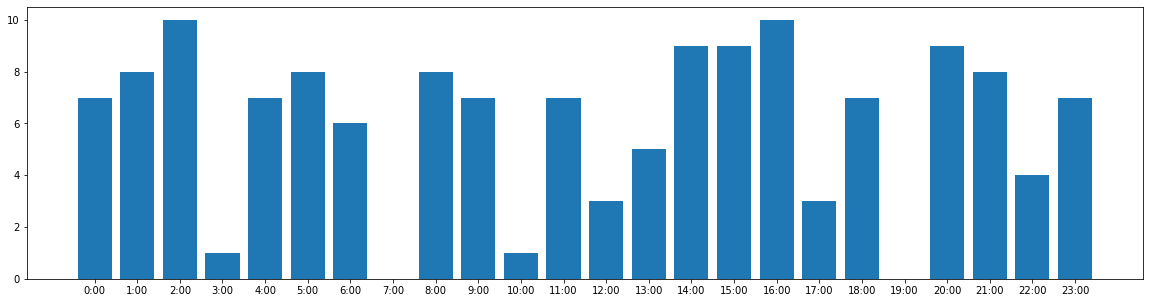

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]
plt.bar(hours, data)

In [15]:
df['hour'] = df['pickup_datetime_py'].dt.hour
count_by_hour = df['hour'].value_counts().compute()
count_by_hour

18    4607632
19    4439331
17    4360870
20    4061868
16    3941394
21    3867436
15    3858801
8     3731887
22    3730118
14    3667596
9     3384956
13    3377153
23    3324910
12    3182016
7     3095123
11    3044517
10    3031697
0     2591041
6     2034703
1     1819551
2     1282445
5     1214553
3     1019967
4      971268
Name: hour, dtype: int64

Text(0, 0.5, 'Number of Taxis Requested (in millions)')

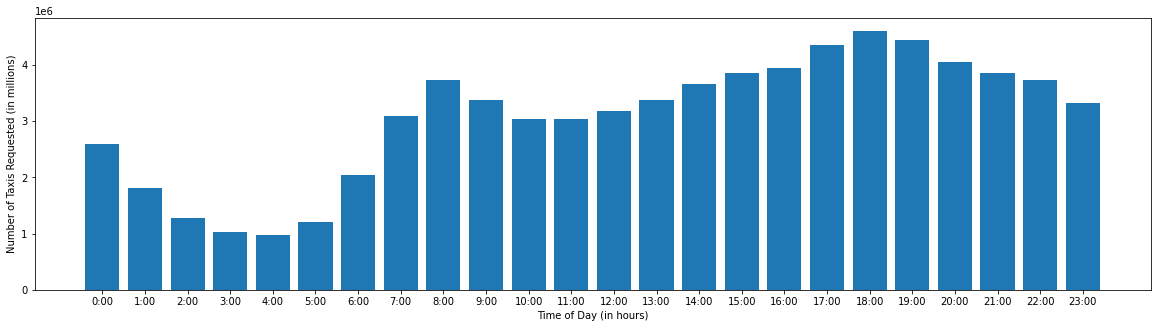

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]
hours = [ str(i)+':00' for i in range(24)] #hours of the day
counts = [1000000, 2000000, 3000000, 4000000]
plt.bar(count_by_hour.index, count_by_hour.values)
plt.xticks(range(len(hours)), hours)
plt.xlabel('Time of Day (in hours)')
plt.ylabel('Number of Taxis Requested (in millions)')

From the plot generated above, we can see that 6pm (18:00) was the hour with the most number of taxis requested, followed by 7pm (19:00) being a close second. Thus 6pm is the most popular time of day to request a taxi

### Question 4. Load the Geospatial Taxi Zone Data Using Geopandas
The fields above have two interesting columns: 'PULocationID' and 'DOLocationID'. These ids correspond to locations in the city called "taxi zones". You will next use the geopandas library to load the latitude and longitude regions that each of the NYC taxi zones correspond to. In the tripdata folder, there is a subfolder called taxi-zones. From that folder you will use geopandas to load the "shp" file. Please look at prior class lectures for an example of how to do this.

Then, plot the loaded shapefile. Your plot should look as follows:
https://github.com/CMSC-13600-Data-Engineering/HW4/blob/main/Screen%20Shot%202022-05-13%20at%205.32.36%20PM.png

In [17]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.3 MB 42.6 MB/s 
     |████████████████████████████████| 16.7 MB 25.8 MB/s 


In [18]:
import geopandas as gpd

In [19]:
os.listdir('/content/drive/My Drive/tripdata/taxi-zones')[1]

'geo_export_8fa447e4-1d62-4164-9635-24c69774a066.shp'

In [20]:
taxi_zones_shp = gpd.read_file('/content/drive/My Drive/tripdata/taxi-zones/geo_export_8fa447e4-1d62-4164-9635-24c69774a066.shp')

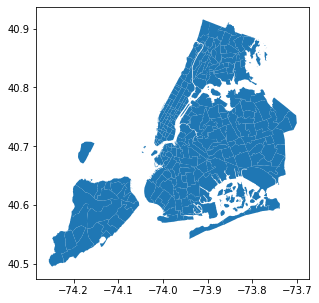

In [21]:
taxi_zones_shp.plot()

### Question 5. Number of Pickup and Dropoffs Across The City
For each taxi zone you will calculate total number of pickups and dropoffs originating from or ending at respectively. Your code should result in two plots: https://github.com/CMSC-13600-Data-Engineering/HW4/blob/main/Screen%20Shot%202022-05-13%20at%205.36.05%20PM.png

https://github.com/CMSC-13600-Data-Engineering/HW4/blob/main/Screen%20Shot%202022-05-13%20at%205.38.29%20PM.png

In [22]:
taxi_zones_shp

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,Brooklyn,256.0,256.0,0.000169,0.067915,Williamsburg (South Side),"POLYGON ((-73.95834 40.71331, -73.95681 40.712..."
259,Bronx,259.0,259.0,0.000395,0.126750,Woodlawn/Wakefield,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
260,Queens,260.0,260.0,0.000422,0.133514,Woodside,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
261,Manhattan,261.0,261.0,0.000034,0.027120,World Trade Center,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."


In [25]:
pu_count = df['PULocationID'].value_counts().compute()
pu_count

61     1212979
79     1018206
76      909655
138     896533
132     880272
        ...   
99        1386
2          137
110        128
105          8
199          3
Name: PULocationID, Length: 262, dtype: int64

In [31]:
pu_count = pu_count.sort_index(ascending=True).rename_axis('PULocationID').reset_index(name='counts')

In [78]:
map = taxi_zones_shp.merge(pu_count, how='left', left_on='location_i', right_on = 'PULocationID')

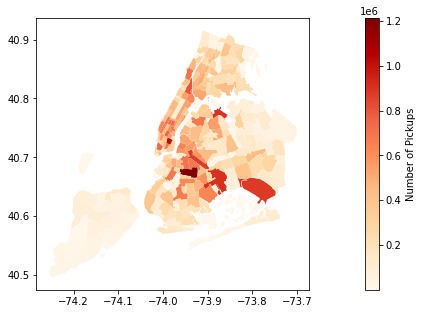

In [79]:
map.plot(column='counts', cmap = 'OrRd', legend=True, legend_kwds={'label': "Number of Pickups", 'orientation': "vertical"})

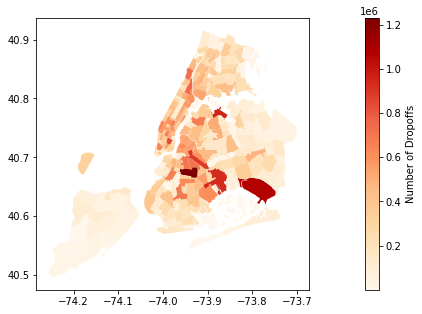

In [39]:
do_count = df['DOLocationID'].value_counts().compute()
do_count = do_count.sort_index(ascending=True).rename_axis('DOLocationID').reset_index(name='counts')
map = taxi_zones_shp.merge(do_count, how='left', left_on='location_i', right_on = 'DOLocationID')
map.plot(column='counts', cmap = 'OrRd', legend=True, legend_kwds={'label': "Number of Dropoffs", 'orientation': "vertical"})

### Question 6. Average Trip Duration in Seconds By Pickup Location
For each pickup location, you will plot a map that considers the average trip duration in seconds. Your map should look something like this:
https://github.com/CMSC-13600-Data-Engineering/HW4/blob/main/Screen%20Shot%202022-05-13%20at%205.40.37%20PM.png

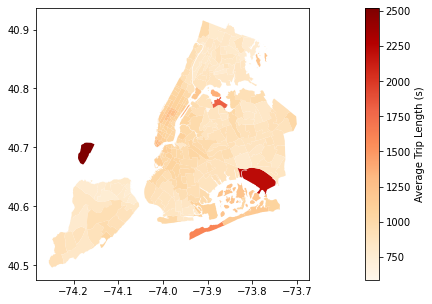

In [41]:
#add code here
avg_trip = df.groupby('PULocationID')['difference_seconds'].mean().compute()
map = taxi_zones_shp.merge(avg_trip, how = 'left', left_on = 'location_i', right_on = 'PULocationID')
map.plot(column = 'difference_seconds', cmap = 'OrRd', legend = True, legend_kwds={'label': "Average Trip Length (s)",'orientation': "vertical"})

### Question 7. The Effects of the COVID Pandemic.
Next, you will only consider the pickups that occur in the month of March 2020. For these trips, we will consider a subset that happened before March 20th, and those that happen on or after March 20th. For each taxi region, you will count the number of trips originating from the region. Then, you will determine the percentage change before and after the pandemic, i.e., (before - after)/before * 100 %. 

Your final result should look like this: https://github.com/CMSC-13600-Data-Engineering/HW4/blob/main/Screen%20Shot%202022-05-13%20at%205.44.36%20PM.png

In [45]:
# add code here
march_df = df[df['pickup_datetime_py'].dt.month == 3].compute()

In [46]:
import pandas as pd

pre_covid = march_df[march_df['pickup_datetime_py'].dt.day < 20].groupby('PULocationID')['hvfhs_license_num'].count()
post_covid = march_df[march_df['pickup_datetime_py'].dt.day >= 20].groupby('PULocationID')['hvfhs_license_num'].count()
merged_df = pd.merge(pre_covid, post_covid, how = 'outer', on = 'PULocationID')
merged_df['rate'] = (abs(merged_df['hvfhs_license_num_x'] - merged_df['hvfhs_license_num_y'])/merged_df['hvfhs_license_num_x'])*100
merged_df

,hvfhs_license_num_x,hvfhs_license_num_y,rate
PULocationID,,,
1,338,24.0,92.899408
2,16,7.0,56.250000
3,26992,7084.0,73.755187
4,43929,5216.0,88.126295
5,2671,518.0,80.606514
...,...,...,...
260,45137,7845.0,82.619580
261,37185,2586.0,93.045583
262,50452,5357.0,89.381987


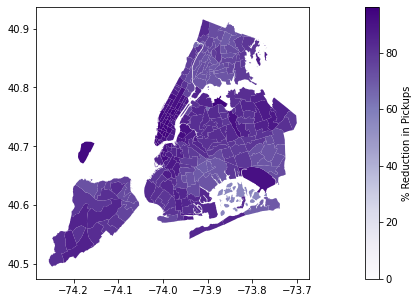

In [66]:
covidmap = taxi_zones_shp.merge(merged_df, how = 'left', left_on = 'location_i', 
                      right_on = 'PULocationID') 
covidmap.plot(column = 'rate', cmap = 'Purples', legend = True, legend_kwds={'label': "% Reduction in Pickups",'orientation': "vertical"})

## Question 8. Businesses in Highly Affected Taxi Zones
Finally, we have also included a dataset of businesses in NYC (Legally_Operating_Businesses.csv):
https://drive.google.com/file/d/1IQal9xJAuxMVZOofE5G1jwNf5ys80Ja_/view?usp=sharing

Over every taxi zone that had more than a 70% drop in traffic, count the number of businesses that are in those zones.

Hint 1. You will have to use the rtree package to merge the business data with the taxi zone data.

Hint 2. You will have to throw away a lot of business listings without lat,long data.

In [48]:
!pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.1 MB/s 


In [70]:
#your code here
import rtree
from shapely.geometry import Polygon, Point

bus_df = pd.read_csv('/content/drive/My Drive/tripdata/Legally_Operating_Businesses.csv')
bus_df = bus_df.dropna(subset=['Longitude', 'Latitude'])
geo_dataset = gpd.GeoDataFrame(bus_df, geometry=gpd.points_from_xy(bus_df['Longitude'], bus_df['Latitude']))
geo_dataset

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location,geometry
3,1245882-DCA,Business,06/30/2022,Active,01/02/2007,Electronic & Appliance Service,"DELTA ELECTRONICS, INC.",NaN,3108,E TREMONT AVE,...,13.0,2073584.0,2053500039,NaN,NaN,NaN,-73.835446,40.838469,"(40.838469099008464, -73.83544554039032)",POINT (-73.83545 40.83847)
7,2096055-DCA,Business,12/31/2022,Active,07/23/2020,Electronics Store,T-MOBILE NORTHEAST LLC,NaN,1231,3RD AVE,...,4.0,1043933.0,1014267501,NaN,NaN,NaN,-73.961024,40.769163,"(40.76916304948403, -73.96102430808294)",POINT (-73.96102 40.76916)
8,0365714-DCA,Business,03/31/2005,Inactive,04/08/1997,Garage,THE GARDENS 75TH STREET OWNERS CORP.,NaN,3538,75TH ST,...,25.0,4029562.0,4012740020,QN28,289.0,"Vehicle Spaces: 85, Bicycle Spaces:",-73.891136,40.750745,"(40.75074488262595, -73.89113569640881)",POINT (-73.89114 40.75074)
9,1076184-DCA,Business,12/31/2004,Inactive,04/02/2001,Tobacco Retail Dealer,"JALIL, MOHAMMED ABDUL",SUNRISE DELICATESSEN,2017,CHURCH AVE,...,40.0,3116556.0,3050810039,BK42,50801.0,NaN,-73.960737,40.650123,"(40.6501225946322, -73.96073707845565)",POINT (-73.96074 40.65012)
12,2078177-DCA,Business,06/30/2022,Active,09/14/2018,Electronic & Appliance Service,QUISQUEYA AUTO SONIDO INC,NaN,3988,10TH AVE,...,10.0,1064880.0,1022300021,NaN,NaN,NaN,-73.916285,40.868064,"(40.868064413367236, -73.91628515587647)",POINT (-73.91629 40.86806)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273863,2101819-DCA,Business,07/31/2023,Active,09/28/2021,Secondhand Dealer - Auto,SUBLIME MOTORS INC,NaN,23320,NORTHERN BLVD,...,19.0,4169907.0,4081660025.0,NaN,NaN,NaN,-73.746433,40.764592,"(40.764592338846526, -73.74643317618512)",POINT (-73.74643 40.76459)
273866,2075372-1-DCA,Business,11/30/2023,Active,07/11/2018,Electronic Cigarette Dealer,HARI KRISHNA STATIONERY STORE INC.,NaN,2055,BARTOW AVE,...,12.0,2097466.0,2051410100.0,BX13,46201.0,NaN,-73.828405,40.869485,"(40.86948501251754, -73.82840504443188)",POINT (-73.82841 40.86949)
273882,2065451-1-DCA,Business,12/31/2023,Active,01/29/2018,Tobacco Retail Dealer,BROTHER'S MINI MARKET INC,NaN,23,AVENUE D,...,2.0,1004395.0,1003730040.0,MN28,2601.0,NaN,-73.978189,40.720750,"(40.720750193314515, -73.9781886021506)",POINT (-73.97819 40.72075)
273917,2072232-1-DCA,Business,11/30/2023,Active,05/31/2018,Electronic Cigarette Dealer,PELHAM GARDENS CANDY CORP,NaN,2454,EASTCHESTER RD,...,13.0,2052925.0,2044780032.0,BX31,312.0,NaN,-73.843316,40.861898,"(40.86189791110499, -73.84331578531881)",POINT (-73.84332 40.86190)


In [71]:
idx = rtree.index.Index()
for i,row in geo_dataset.iterrows():
  idx.insert(i, row['geometry'].bounds)

geo_dataset

,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location,geometry
3,1245882-DCA,Business,06/30/2022,Active,01/02/2007,Electronic & Appliance Service,"DELTA ELECTRONICS, INC.",NaN,3108,E TREMONT AVE,...,13.0,2073584.0,2053500039,NaN,NaN,NaN,-73.835446,40.838469,"(40.838469099008464, -73.83544554039032)",POINT (-73.83545 40.83847)
7,2096055-DCA,Business,12/31/2022,Active,07/23/2020,Electronics Store,T-MOBILE NORTHEAST LLC,NaN,1231,3RD AVE,...,4.0,1043933.0,1014267501,NaN,NaN,NaN,-73.961024,40.769163,"(40.76916304948403, -73.96102430808294)",POINT (-73.96102 40.76916)
8,0365714-DCA,Business,03/31/2005,Inactive,04/08/1997,Garage,THE GARDENS 75TH STREET OWNERS CORP.,NaN,3538,75TH ST,...,25.0,4029562.0,4012740020,QN28,289.0,"Vehicle Spaces: 85, Bicycle Spaces:",-73.891136,40.750745,"(40.75074488262595, -73.89113569640881)",POINT (-73.89114 40.75074)
9,1076184-DCA,Business,12/31/2004,Inactive,04/02/2001,Tobacco Retail Dealer,"JALIL, MOHAMMED ABDUL",SUNRISE DELICATESSEN,2017,CHURCH AVE,...,40.0,3116556.0,3050810039,BK42,50801.0,NaN,-73.960737,40.650123,"(40.6501225946322, -73.96073707845565)",POINT (-73.96074 40.65012)
12,2078177-DCA,Business,06/30/2022,Active,09/14/2018,Electronic & Appliance Service,QUISQUEYA AUTO SONIDO INC,NaN,3988,10TH AVE,...,10.0,1064880.0,1022300021,NaN,NaN,NaN,-73.916285,40.868064,"(40.868064413367236, -73.91628515587647)",POINT (-73.91629 40.86806)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273863,2101819-DCA,Business,07/31/2023,Active,09/28/2021,Secondhand Dealer - Auto,SUBLIME MOTORS INC,NaN,23320,NORTHERN BLVD,...,19.0,4169907.0,4081660025.0,NaN,NaN,NaN,-73.746433,40.764592,"(40.764592338846526, -73.74643317618512)",POINT (-73.74643 40.76459)
273866,2075372-1-DCA,Business,11/30/2023,Active,07/11/2018,Electronic Cigarette Dealer,HARI KRISHNA STATIONERY STORE INC.,NaN,2055,BARTOW AVE,...,12.0,2097466.0,2051410100.0,BX13,46201.0,NaN,-73.828405,40.869485,"(40.86948501251754, -73.82840504443188)",POINT (-73.82841 40.86949)
273882,2065451-1-DCA,Business,12/31/2023,Active,01/29/2018,Tobacco Retail Dealer,BROTHER'S MINI MARKET INC,NaN,23,AVENUE D,...,2.0,1004395.0,1003730040.0,MN28,2601.0,NaN,-73.978189,40.720750,"(40.720750193314515, -73.9781886021506)",POINT (-73.97819 40.72075)
273917,2072232-1-DCA,Business,11/30/2023,Active,05/31/2018,Electronic Cigarette Dealer,PELHAM GARDENS CANDY CORP,NaN,2454,EASTCHESTER RD,...,13.0,2052925.0,2044780032.0,BX31,312.0,NaN,-73.843316,40.861898,"(40.86189791110499, -73.84331578531881)",POINT (-73.84332 40.86190)


In [72]:
business_df = covidmap[covidmap['rate'] >= 70]
business_df["business_count"] = " "
business_df

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,hvfhs_license_num_x,hvfhs_license_num_y,rate,business_count
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",338.0,24.0,92.899408,
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",26992.0,7084.0,73.755187,
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",43929.0,5216.0,88.126295,
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",2671.0,518.0,80.606514,
5,Staten Island,6.0,6.0,0.000606,0.150491,Arrochar/Fort Wadsworth,"POLYGON ((-74.06367 40.60220, -74.06351 40.602...",5000.0,1283.0,74.340000,
...,...,...,...,...,...,...,...,...,...,...,...
258,Brooklyn,256.0,256.0,0.000169,0.067915,Williamsburg (South Side),"POLYGON ((-73.95834 40.71331, -73.95681 40.712...",92583.0,9888.0,89.319854,
259,Bronx,259.0,259.0,0.000395,0.126750,Woodlawn/Wakefield,"POLYGON ((-73.85107 40.91037, -73.85207 40.909...",33115.0,9476.0,71.384569,
260,Queens,260.0,260.0,0.000422,0.133514,Woodside,"POLYGON ((-73.90175 40.76078, -73.90147 40.759...",45137.0,7845.0,82.619580,
261,Manhattan,261.0,261.0,0.000034,0.027120,World Trade Center,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",37185.0,2586.0,93.045583,


In [80]:
for i, row in business_df.iterrows(): 
    poly = row.geometry.bounds
    count = len(list(idx.intersection(poly)))
    business_df.loc[i, 'business_count'] = count
    count = 0
  
business_df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,hvfhs_license_num_x,hvfhs_license_num_y,rate,business_count
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",338.0,24.0,92.899408,0
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",26992.0,7084.0,73.755187,702
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",43929.0,5216.0,88.126295,573
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",2671.0,518.0,80.606514,329
5,Staten Island,6.0,6.0,0.000606,0.150491,Arrochar/Fort Wadsworth,"POLYGON ((-74.06367 40.60220, -74.06351 40.602...",5000.0,1283.0,74.340000,565
...,...,...,...,...,...,...,...,...,...,...,...
258,Brooklyn,256.0,256.0,0.000169,0.067915,Williamsburg (South Side),"POLYGON ((-73.95834 40.71331, -73.95681 40.712...",92583.0,9888.0,89.319854,916
259,Bronx,259.0,259.0,0.000395,0.126750,Woodlawn/Wakefield,"POLYGON ((-73.85107 40.91037, -73.85207 40.909...",33115.0,9476.0,71.384569,911
260,Queens,260.0,260.0,0.000422,0.133514,Woodside,"POLYGON ((-73.90175 40.76078, -73.90147 40.759...",45137.0,7845.0,82.619580,2705
261,Manhattan,261.0,261.0,0.000034,0.027120,World Trade Center,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",37185.0,2586.0,93.045583,824


     location_i business_count
0           1.0              0
2           3.0            702
3           4.0            573
4           5.0            329
5           6.0            565
..          ...            ...
258       256.0            916
259       259.0            911
260       260.0           2705
261       261.0            824
262       262.0           1020

[247 rows x 2 columns]


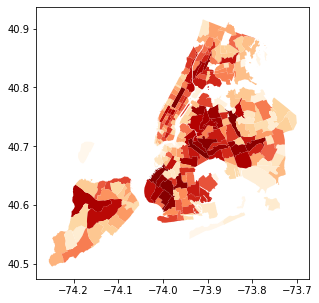

In [81]:
business_df.plot(column='business_count', cmap = 'OrRd')
print(business_df[['location_i', 'business_count']])